In [10]:
import os
import cv2
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


class USDataset(Dataset):
    def __init__(self, path, transform=None):        
        self.path_images = glob.glob(path)
        self.transform = transform
        
        self.resize = A.Compose([ 
            A.Resize(width=512, height=512, p=1.0)])
        
    def __len__(self):
        return len(self.path_images)
    
    
    def __getitem__(self, idx):
        image = cv2.imread(self.path_images[idx], cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = self.transform(image=image)
        
        transformed_image = transformed['image']
        transoformed_image = transformed_image.permute(2,0,1).float()
        
        image = self.resize(image=image)['image']
        
        return transformed_image, image, self.path_images[idx]

    
batch_size = 1
pred_transform = A.Compose([ 
        A.Resize(width=512, height=512, p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2()
    ])

pred_dataset = USDataset('data/roi/*.jpg', transform=pred_transform)
pred_dataloader = DataLoader(pred_dataset, batch_size=batch_size)


In [2]:
LABEL_TO_COLOR = {
    0: [0, 0, 0], # background 
    1: [0, 255, 0], # gallbladder
    2: [255, 255, 0], # kidney
    3: [0, 255, 255], # adrenals
    4: [100, 0, 100], # liver
    5: [0, 0, 255], # pancreas
    6: [255, 0, 0], # vessels
    7: [255, 0, 255], # spleen
    8: [255, 255, 255], # bones    
}

def mask2rgb(mask):
    rgb = np.zeros(mask.shape+(3,), dtype=np.uint8)
    
    for i in np.unique(mask):
        rgb[mask==i] = LABEL_TO_COLOR[i]
            
    return rgb

def rgb2mask(rgb):
    mask = np.zeros((rgb.shape[0], rgb.shape[1]))

    for k, v in LABEL_TO_COLOR.items():
        mask[np.all(rgb==v, axis=2)] = k
        
    return mask

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import jaccard_index

class Unet(pl.LightningModule):
    def __init__(self, n_channels, n_classes):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = True

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1)
                
                return self.conv(x)

            
        self.inc = double_conv(self.n_channels, 64)
        
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        
        self.out = nn.Conv2d(64, self.n_classes, kernel_size=1)

        
    def forward(self, x):
        x1 = self.inc(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        return self.out(x)

    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss

    
    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        
        pred = F.softmax(y_hat, dim=1)
        pred = torch.argmax(pred, dim=1)
        
        pred[pred != 4] = 0
        pred[pred == 4] = 1
        
        y[y != 4] = 0
        y[y == 4] = 1
        
        binary_iou = jaccard_index(pred, y, num_classes=2)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_binary_iou', binary_iou, on_step=False, on_epoch=True, prog_bar=True)
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


unet = Unet(3, 9)
ckpt_fname = "Unet-epoch=024-valid_loss=0.1967.ckpt"
unet = unet.load_from_checkpoint("weights/Unet_finetuning/" + ckpt_fname, n_channels=3, n_classes=9)

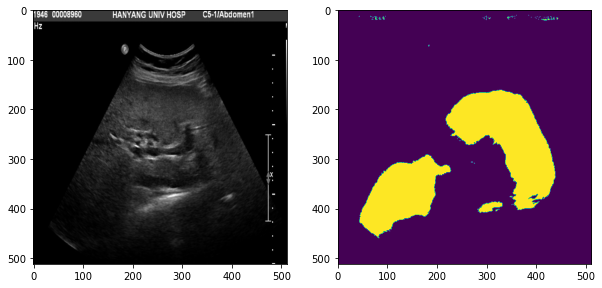

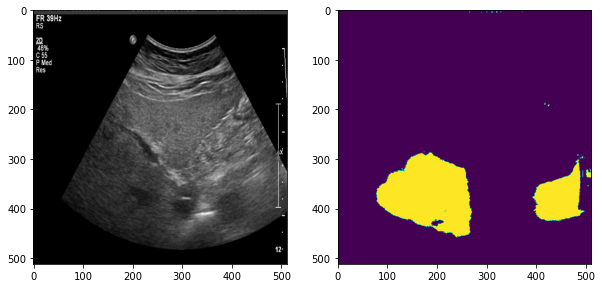

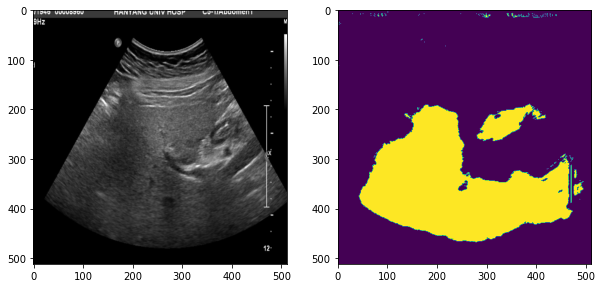

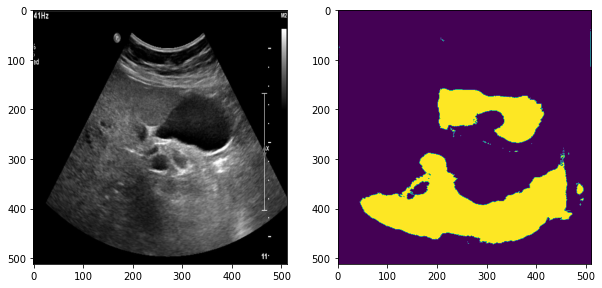

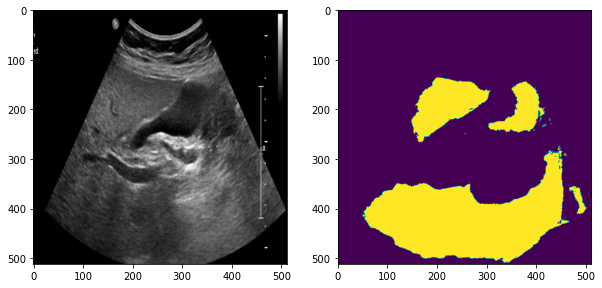

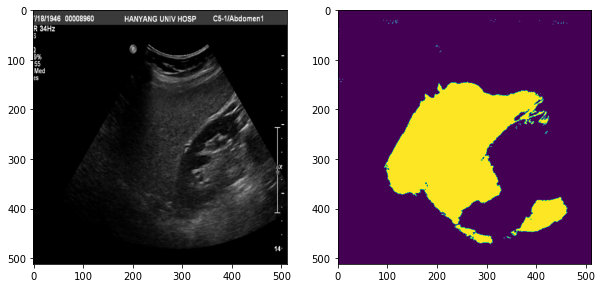

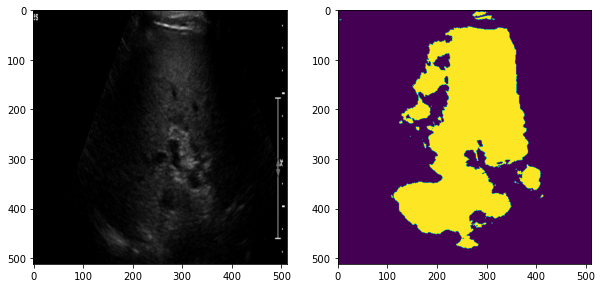

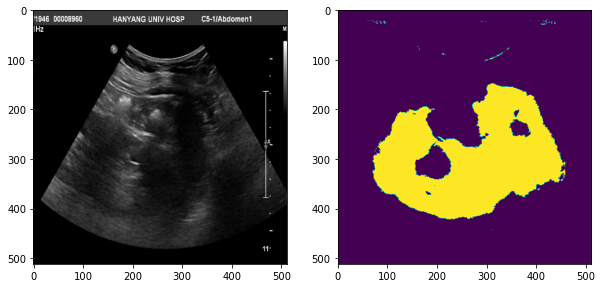

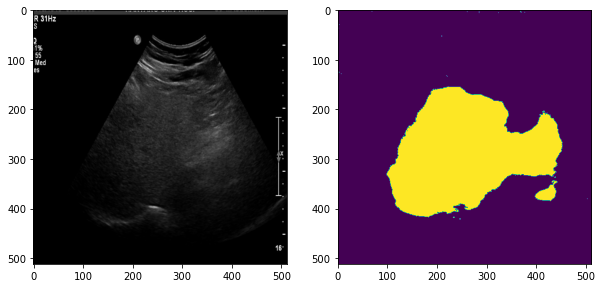

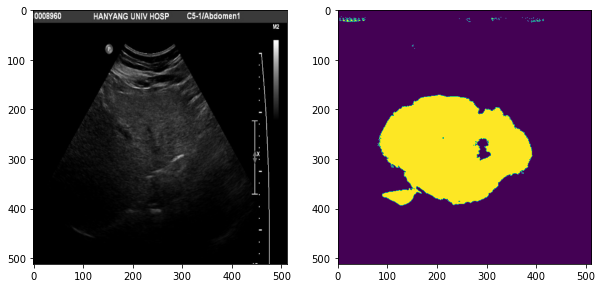

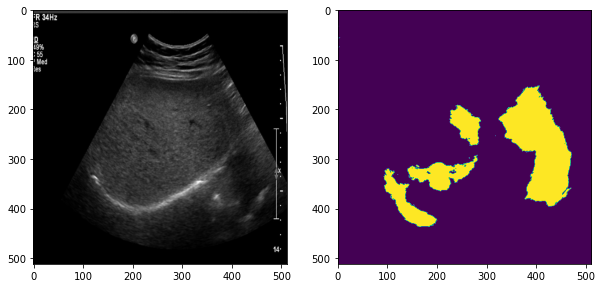

In [6]:
import matplotlib.pyplot as plt

ct = 0

unet.eval()
for batch in pred_dataloader:
    x, orig_image, fname = batch
    logits = unet(x)
    pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
    
    pred[pred != 4] = 0
    pred[pred == 4] = 1
    
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    image = orig_image[0]
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    liver = pred.detach().moveaxis(0, -1).numpy()
    plt.imshow(liver)
    plt.show()
    
    if ct < 10:
        ct += 1
    else:
        break

In [19]:
import shutil
from tqdm import tqdm

threshold = 0.1

unet.eval()
unet.to("cuda:1")

for batch in tqdm(pred_dataloader):
    x, orig_image, fname = batch
    logits = unet(x.to('cuda:1'))
    pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
    
    pred[pred != 4] = 0
    pred[pred == 4] = 1
    
    liver = pred.detach().to("cpu").numpy()
    
    if np.sum(liver >= 0.3) / np.size(liver) >= threshold:
        source = fname[0]
        dest = source.replace("roi", "roi_sampled")
        shutil.copy(source, dest)

100%|█████████████████████████████████████| 36073/36073 [16:53<00:00, 35.59it/s]
